# Libraries

In [9]:
from pathlib import Path
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

import nibabel as nib
from intensity_normalization.typing import Modality, TissueType
from intensity_normalization.normalize.fcm import FCMNormalize
from intensity_normalization.plot.histogram import HistogramPlotter, plot_histogram

from metadata import ImageDataset, patient
import utils

In [2]:
notebook_path = Path().cwd()
repo_path = notebook_path.parent
print(f'The current directory is: {notebook_path}')

The current directory is: /home/ricardino/Documents/MAIA/tercer_semestre/MISA/final_project/MISA_FINAL_PROJECT/notebooks


In [3]:
def bias_correct(inputImage):
    """Apply bias field correction to sitk image

    Args:
        inputImage (sit im): image to apply correction

    Returns:
        sitk im: corrected image
    """
    inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)
    return sitk.N4BiasFieldCorrection(inputImage)

# Main

# Trying the intensity normalisation library

Let's check the library for the normalisation of the data.

In [5]:
im_data = ImageDataset(set_name='Training')
id = im_data.IDs[1] #get the first patient ID
pat = patient(id, im_data) #define patient)

This first example considers one image and its normalization using Fuzzy C-Means.

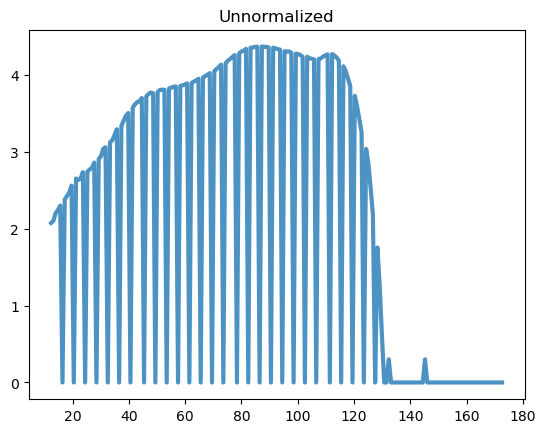

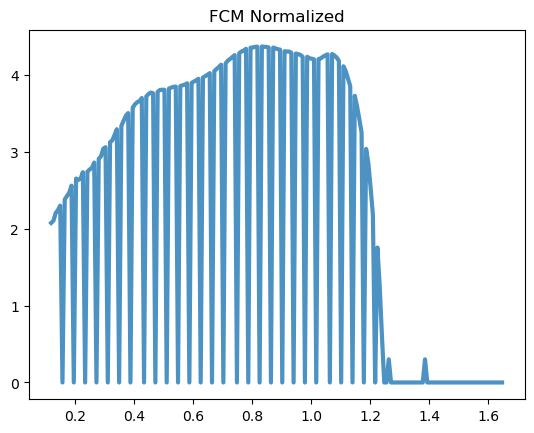

In [5]:
#we apply the normalisation library intensity_normalization
import nibabel as nib
from intensity_normalization.typing import Modality, TissueType
from intensity_normalization.normalize.fcm import FCMNormalize

#load nib image
image = nib.load(pat.im_path).get_fdata()
#normalize
fcm_norm = FCMNormalize(tissue_type=TissueType.WM) #normilize object
norm_im = fcm_norm(image, modality=Modality.T1)


plot_histogram(image)
plt.title("Unnormalized")
plt.show()

plot_histogram(norm_im)
plt.title("FCM Normalized")
plt.show()

This is  little time consuiming and it only changed the scale of the intensity values. Let's check what happens when using the whole dataset.

In [18]:
#all the images paths
filenames = [patient(id, im_data).im_path for id in im_data.IDs]
#load all the images
images = [nib.load(fn).get_fdata() for fn in filenames]
#normalize all the images
normed = [fcm_norm(img) for img in images]

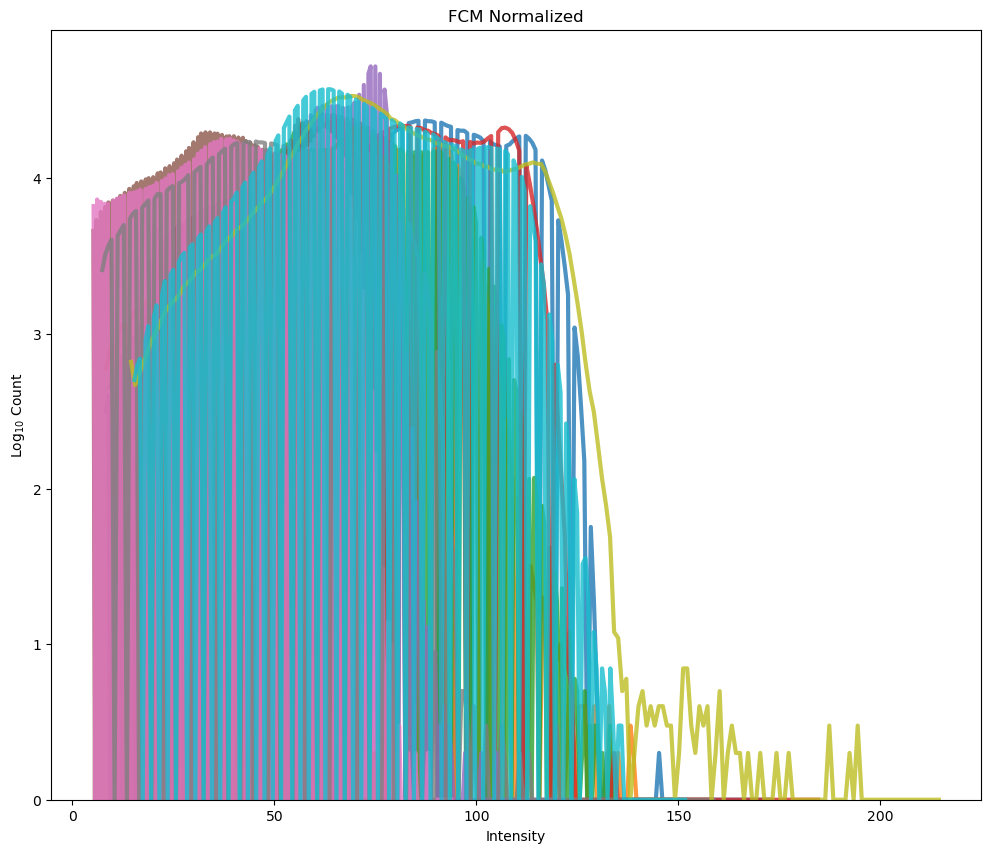

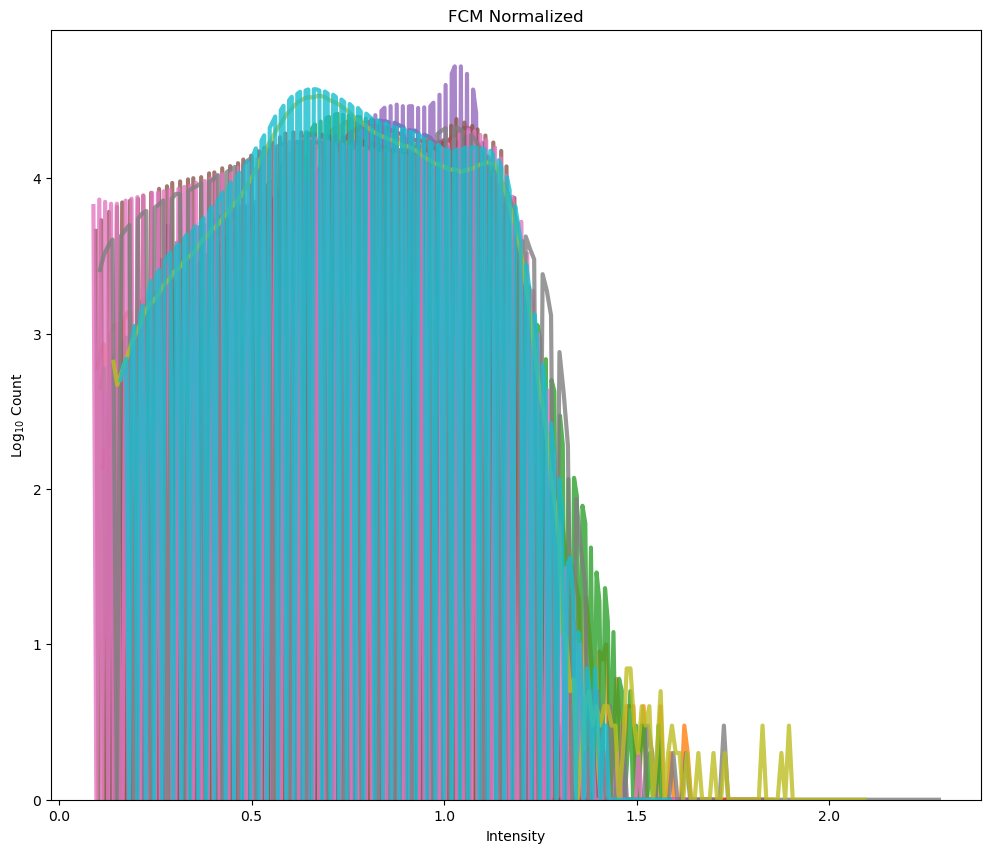

In [25]:
hp = HistogramPlotter(title="FCM Normalized")
_ = hp(images, masks=None)
plt.show()
_ = hp(normed, masks=None)
plt.show()

So all training images intensities are mapped between 0 and 2 basically. Let's see this in the actual images

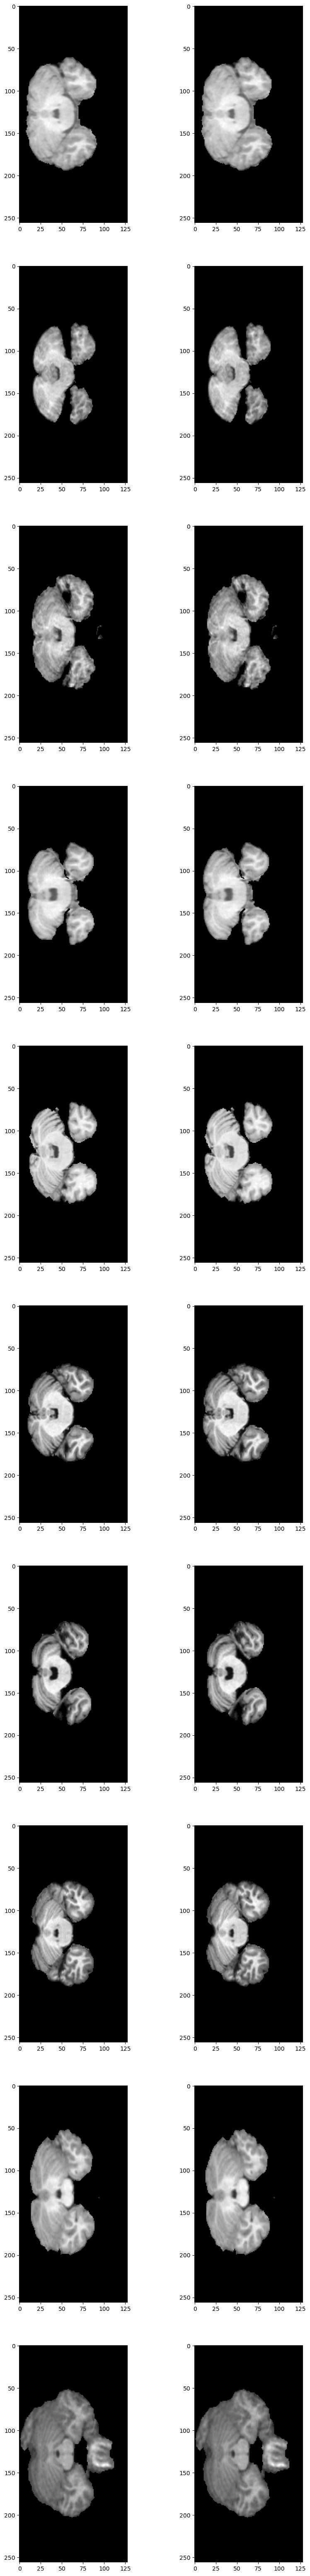

In [ ]:
#plot all images and normed images next ot each other
cmap = 'gray'
slice_num = 100
fig, axs = plt.subplots(10, 2, figsize=(10, 80))
for i in range(10):
    axs[i, 0].imshow(images[i][:, :, slice_num], cmap=cmap)
    axs[i, 1].imshow(normed[i][:, :, slice_num], cmap=cmap)
    

Now we try to use sample-based normalisation method.

In [55]:
from intensity_normalization.normalize.lsq import LeastSquaresNormalize
lsq_normalizer = LeastSquaresNormalize()
lsq_normalizer.fit(images)
normalized = [lsq_normalizer(image) for image in images]

As before, we check the histogram of the intensities of the images.

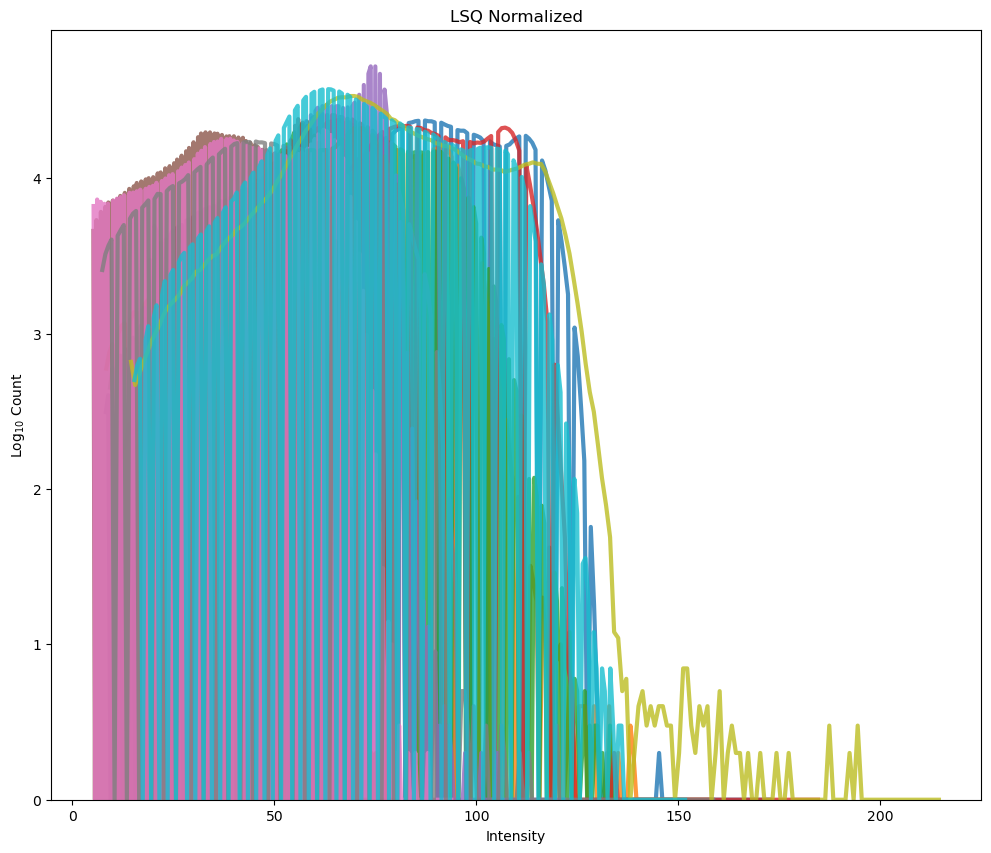

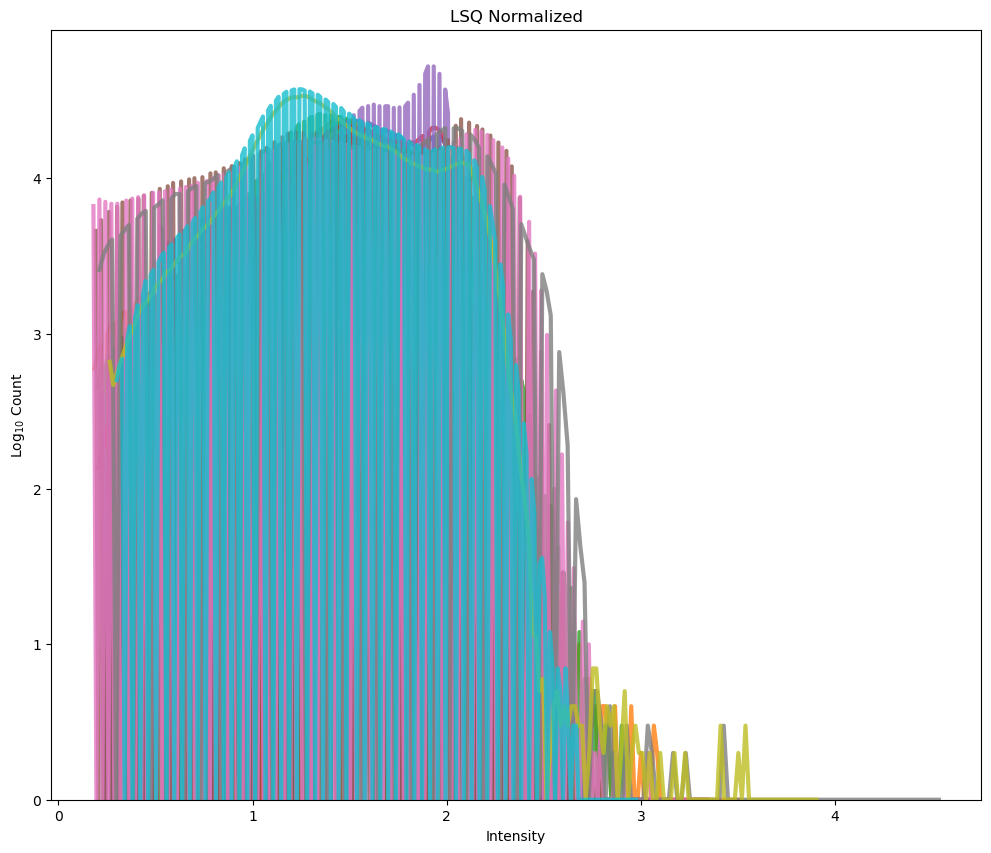

In [58]:
hp = HistogramPlotter(title="LSQ Normalized")
_ = hp(images, masks=None)
plt.show()
_ = hp(normalized, masks=None)
plt.show()

# Applying preprocessing ans save images

First we apply bias field removal to the images and save them at each patient folder

In [4]:
im_data = ImageDataset(set_name='Validation')

for id in im_data.IDs:
        
    pat = patient(id, im_data) #define patient
    #lets first save the images with the bias field correction
    corrected_im = bias_correct(pat.im('sitk'))
    #save the file as nifti image with preposessed label
    filename = Path(pat.im_path).parent / (Path(pat.im_path).parent.stem + '_preprocessed.nii.gz')
    corrected_array = sitk.GetArrayFromImage(corrected_im)
    utils.save_as_nifti(corrected_array, str(filename), pat.im_path)

Now we apply the normalisation to the images and save them at each patient folder with the suffix _norm

In [6]:
#define normalisation object
fcm_norm = FCMNormalize(tissue_type=TissueType.WM)
#get all the images paths
filenames = [patient(id, im_data).im_path_preprocessed for id in im_data.IDs]
#load all the images
images = [nib.load(fn).get_fdata() for fn in filenames]
#normalize all the images
normed = [fcm_norm(img) for img in images]

#we save the images in the same folder just adding the ssufix norm
for i, id in enumerate(im_data.IDs):
    pat = patient(id, im_data)
    name = pat.im_path_preprocessed #original name
    name = Path(name).parent / (Path(name).parent.stem + '_norm.nii.gz') #changed name
    nib.Nifti1Image(normed[i], nib.load(pat.im_path).affine).to_filename(name)

We check that the histograms were indeed normalised.

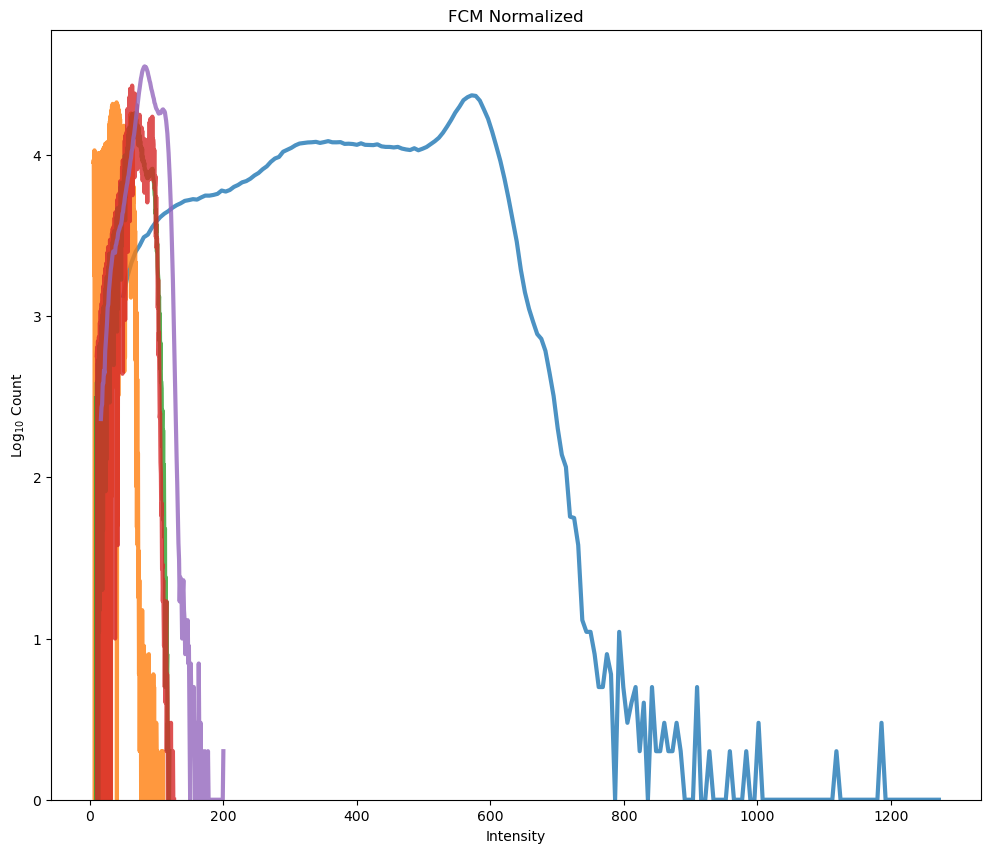

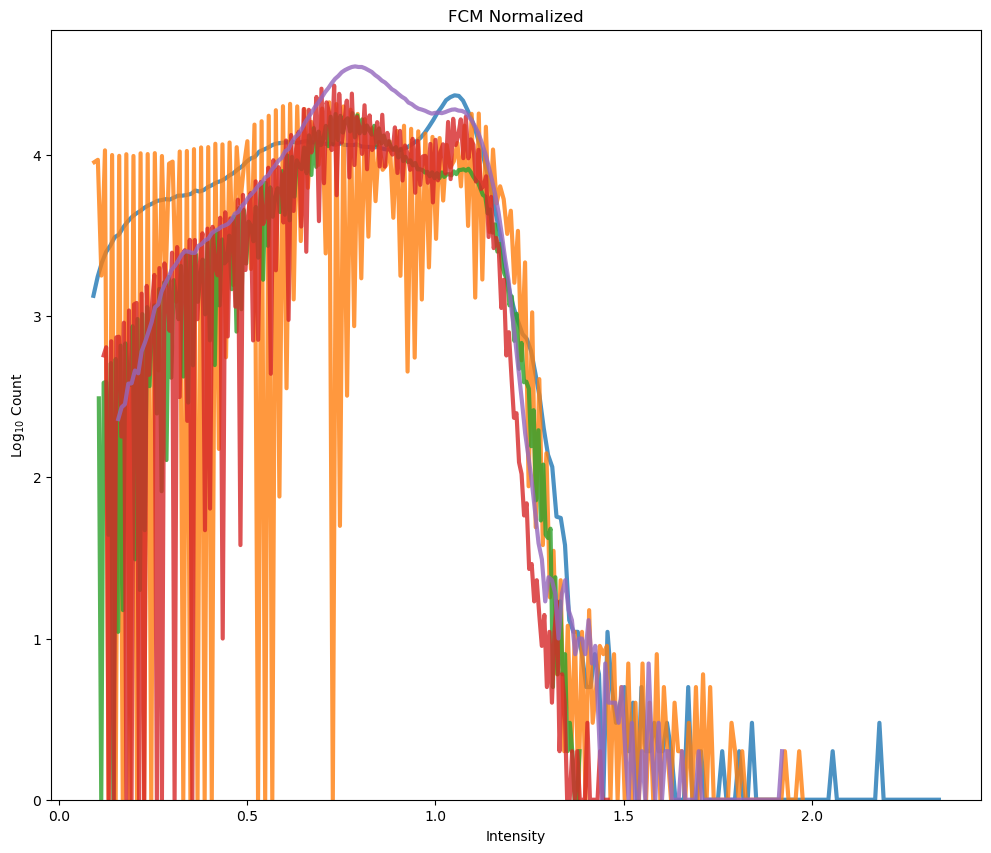

In [10]:
hp = HistogramPlotter(title="FCM Normalized")
_ = hp(images, masks=None)
plt.show()
_ = hp(normed, masks=None)
plt.show()

(array([7.474022e+06, 1.243110e+05, 2.288920e+05, 2.343700e+05,
        3.156790e+05, 1.121500e+04, 7.600000e+01, 2.000000e+01,
        1.300000e+01, 1.000000e+01]),
 array([0.        , 0.23425831, 0.46851663, 0.70277494, 0.93703325,
        1.17129157, 1.40554988, 1.63980819, 1.87406651, 2.10832482,
        2.34258313]),
 <BarContainer object of 10 artists>)

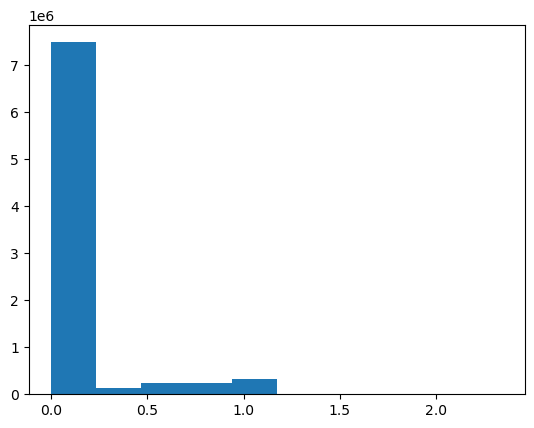

In [17]:
im_data = ImageDataset(set_name='Validation')
id = im_data.IDs[0]
pat = patient(id, im_data)
plt.hist(pat.im(format='np', preprocess=True).ravel())